In [1]:
"""
Title: Grad-CAM class activation visualization
Author: [fchollet](https://twitter.com/fchollet)
Date created: 2020/04/26
Last modified: 2021/03/07
Description: How to obtain a class activation heatmap for an image classification model.
Accelerator: GPU
"""

"""
Adapted from Deep Learning with Python (2017).

## Setup
"""

import os
import cv2
os.environ["KERAS_BACKEND"] = "tensorflow"
import wandb
import numpy as np
import tensorflow as tf
import keras

# Display
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt

from thin_section_rock_analysis.machine_learning.network.architecture import SimCLR
from thin_section_rock_analysis.plotting.augmentation import plot_single_image

2024-10-08 12:45:16.474068: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-08 12:45:16.490849: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-08 12:45:16.495772: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-08 12:45:16.509545: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-08 12:45:17.269205: W tensorflow/compiler/tf2

In [2]:
"""
## The Grad-CAM algorithm
"""

def get_network():
    training_directory = "../../0_data/binary/train"
    validation_directory = "../../0_data/binary/validation"
    all_training = "../../0_data/binary/all_training"
    test_directory = "../../0_data/binary/test"

    network = SimCLR(path="2_contrastive_learning/models/pretrained_r50_1x_sk0/", learning_rate=0.1, momentum=0.9, weight_decay=0., train_dir=training_directory, val_dir=validation_directory, test_dir=test_directory,
                                epochs=20, finetune_epochs=30, batch_size=1)
    return network

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(preds, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


"""
## Create a superimposed visualization
"""
def save_and_display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    # img = keras.utils.load_img(img_path)
    # img = keras.utils.img_to_array(img)
    img = np.uint8(255 * img)
    
    #heatmap[heatmap == 0] = np.nan 

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    return superimposed_img

In [3]:
"""
## Configurable parameters

You can change these to another model.

To get the values for `last_conv_layer_name` use `model.summary()`
to see the names of all layers in the model.
"""

model_builder = keras.applications.InceptionResNetV2
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "conv_7b"


In [4]:
network = get_network()
train_ds, valid_ds, class_weights = network.fetch_for_train()

def get_img_array():
    images = []
    for data_batch in train_ds.take(10):
        im, labels = data_batch
        one_img = np.array(im/255.)
        images.append(one_img[0,...])
    return np.array(images)

I0000 00:00:1728391519.233726 1016459 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728391519.284999 1016459 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728391519.285228 1016459 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728391519.286336 1016459 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Found 7540 files belonging to 2 classes.
Found 4849 files belonging to 2 classes.


In [5]:
"""
## Let's test-drive it
"""

# Prepare image
img_array = get_img_array()

# Make model
best_model = wandb.restore('simclr_model.weights.h5', run_path="freja-thoresen/SimCLR/lrcnvnrs")
print(best_model.name)
model = keras.applications.InceptionResNetV2(include_top=False, weights=best_model.name)

2024-10-08 12:45:25.697850: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


/home/spaceship/users/freja_thoresen/thin-slice-classifier/2_contrastive_learning/notebooks/simclr_model.weights.h5


2024-10-08 12:45:29.479582: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/home/spaceship/miniconda3/envs/tf2.17_cudnn8.9.7/lib/python3.12/site-packages/keras/src/models/functional.py:218: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_780']. Received: the structure of inputs=*
  warnings.warn(
2024-10-08 12:45:31.278692: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1728391532.120744 1016459 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728391532.135469 1016459 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728391532.136113 1016459 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728391532.136712 1016459 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy

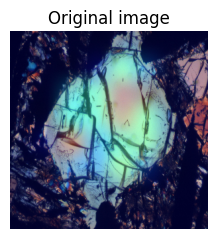

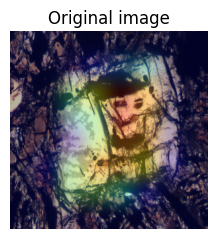

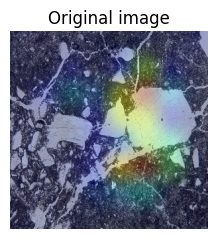

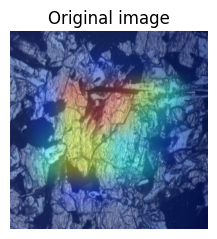

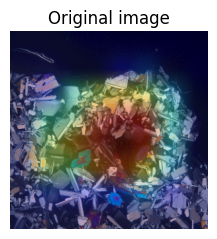

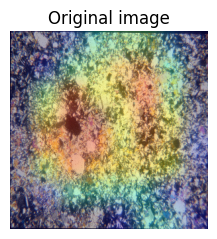

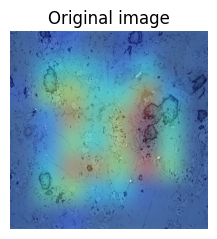

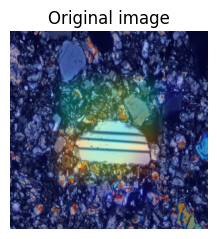

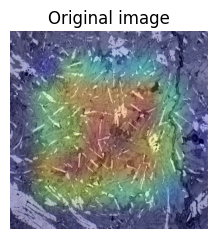

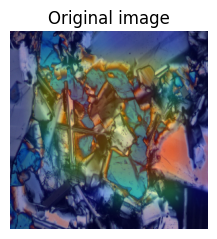

In [6]:
"""
We generate class activation heatmaps
"""
plot_activation = False
img_array = get_img_array()

for i in range(0, len(img_array)):
    #plot_single_image(img_array[i])
    
    heatmap = make_gradcam_heatmap(img_array[i:i+1], model, last_conv_layer_name, pred_index=None)

    superimposed_img = save_and_display_gradcam(img_array[i], heatmap, cam_path=f'../figures/grad_cam/{i} Grad Superimposed image.png')

    #plot_single_image(heatmap, title='Activation heatmap', save_name=f'{i} Grad Activation heatmap')
    plot_single_image(superimposed_img, save_name=f'../figures/grad_cam/{i} Grad Superimposed image', save=False) #title='Superimposed image',
    # plot_single_image(img_array[i], title='Original image', save_name=f'../figures/grad_cam/{i} Original image')

    if plot_activation:
        fig, ax = plt.subplots(figsize=(2.5, 2.5))  # Adjust figsize as needed
        ax.imshow(heatmap,cmap='jet')
        ax.axis('off')  # Remove axes
        plt.gca().set_title('Activation heatmap')
        plt.tight_layout()
        plt.savefig(f'../figures/grad_cam/{i} Grad Activation heatmap.png', dpi=500)
        plt.show()